<a href="https://colab.research.google.com/github/alexsanderthorne/formacaoMachineLearningSpecialist/blob/main/transfer_learning_cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
tf.__version__

'2.15.0'

In [129]:
#Conectando ao google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Realizando a extração do arquivo zip.

In [130]:
path = '/content/drive/MyDrive/cat_dog.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()


Visualizando um imagem da pasta de treinamento cat.

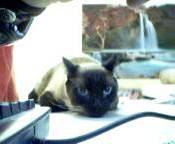

In [131]:
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.5.jpg')

visualizando uma imagem da pasta de treinamento dog.

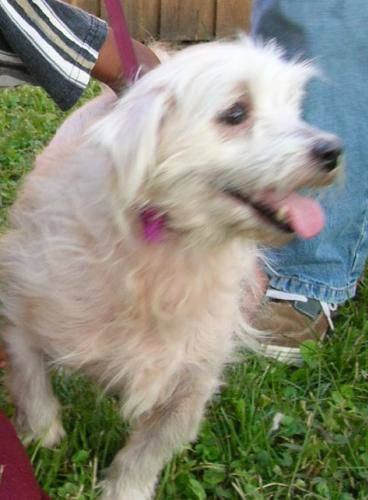

In [132]:
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/dog/dog.9.jpg')

realizando o redimensionamento e a normalização no conjunto de treinamento.

In [133]:
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/cat_dog/training_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.




Visualizando o comportamento das imagens apenas para uma melhor compreensão das alterações realizadas.


Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


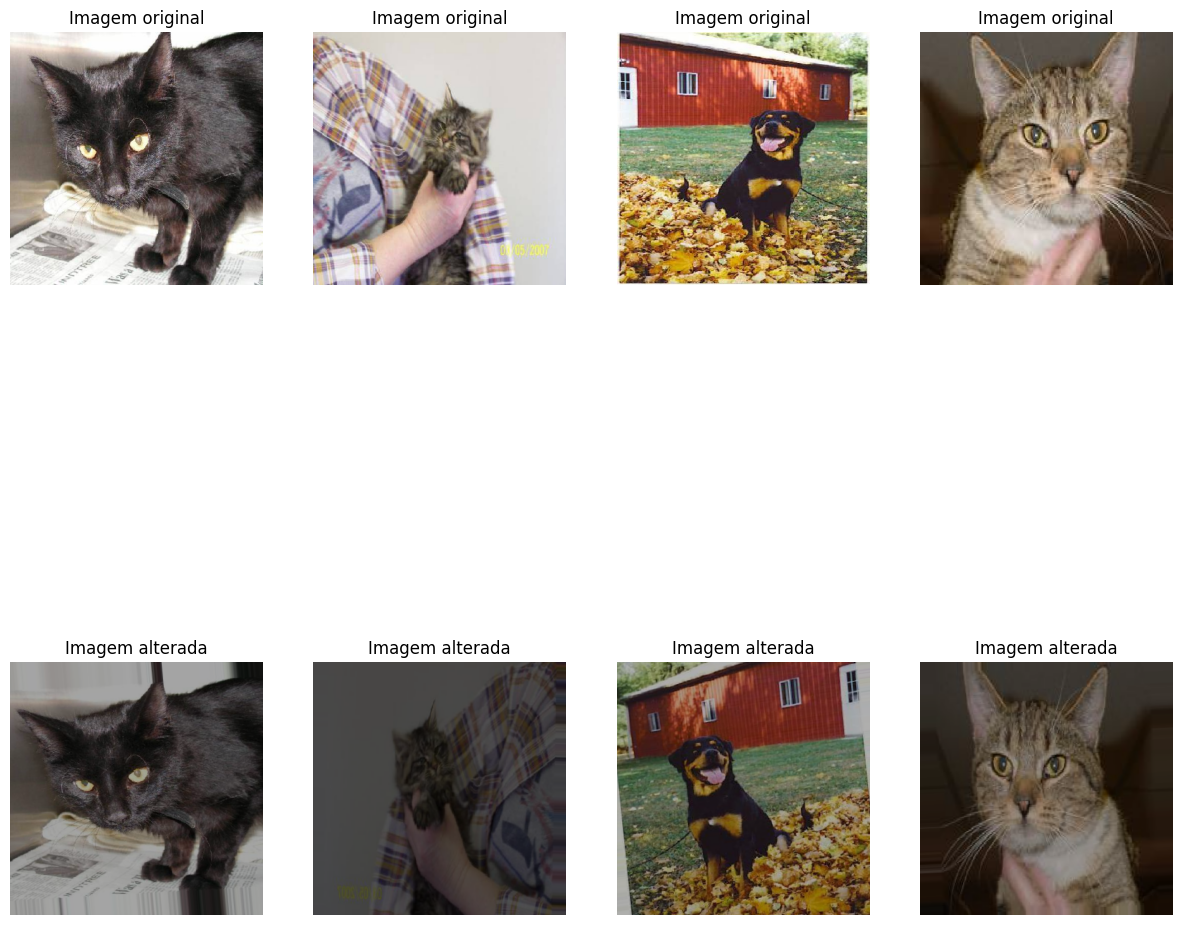

In [134]:
# Alterando as imagens.
datagen = ImageDataGenerator(
        rotation_range=7, # Rotação
        zoom_range=0.2, # aplicano 20% de zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brilho

# Imagem sem alteração.
datanorm = ImageDataGenerator()

# Conjunto com alterações
treino_alterado = datagen.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400), # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  class_mode="binary", # classes
                  seed=2020 # para que os resultados sejam reproduzidos
                  )

# Conjunto sem sofrer alterações
treino_normal = datanorm.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400),
                  color_mode="rgb",
                  batch_size=1,
                  class_mode="binary",
                  seed=2020
                  )

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

# Plotando 5 imagens
for i in range(4):

  # convertendo a imagem para inteiro
  image = next(treino_alterado)[0].astype('uint8')
  image2 = next(treino_normal)[0].astype('uint8')

  # alterando o formato (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = np.squeeze(image)
  image2 = np.squeeze(image2)


  # plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')

realizando o redimensionamento e a normalização no conjunto de teste.


In [135]:
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/cat_dog/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


Rede neural pré treinada


In [136]:
# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

In [137]:
# informações das camadas do modelo base.
modelo_base.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [138]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)

154

In [139]:
# Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
  layer.trainable = False

In [140]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [141]:
(1280 + 2) / 2

641.0

In [142]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

Construção e treinamento da rede neural

In [143]:
# Agora literalmente realizando a ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [144]:
# visualizando as informações das camadas.
network.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [145]:
# Adicionamos as 6 camadas finais ao modelo.
len(network.layers)

160

In [146]:
# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                metrics = ['accuracy'])

In [147]:
# Realizando o treimanto com 5 epocas.
historico = network.fit(dataset_treinamento, epochs=5)

Epoch 1/5
32/32 [==============================] - 84s 2s/step - loss: 0.2167 - accuracy: 0.9145
Epoch 2/5
32/32 [==============================] - 77s 2s/step - loss: 0.1050 - accuracy: 0.9565
Epoch 3/5
32/32 [==============================] - 77s 2s/step - loss: 0.0897 - accuracy: 0.9645
Epoch 4/5
32/32 [==============================] - 79s 2s/step - loss: 0.0893 - accuracy: 0.9653
Epoch 5/5
32/32 [==============================] - 77s 2s/step - loss: 0.0755 - accuracy: 0.9678


In [148]:
# Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

1000/1000 [==============================] - 24s 22ms/step - loss: 0.0836 - accuracy: 0.9680


[0.08358454704284668, 0.9679999947547913]

In [149]:
# Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

1000/1000 [==============================] - 25s 23ms/step


array([[7.3814023e-01, 2.6185977e-01],
       [9.9359518e-01, 6.4048045e-03],
       [9.9999785e-01, 2.1939848e-06],
       ...,
       [8.2217477e-02, 9.1778260e-01],
       [1.8673111e-02, 9.8132688e-01],
       [5.6151231e-07, 9.9999940e-01]], dtype=float32)

In [150]:
# previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] # 10 primeiros registros.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [151]:
# usando a função de acurária do sklearn apenas para comparar se os resultados estão corretos.
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.968

In [152]:
network.evaluate(dataset_teste)

1000/1000 [==============================] - 22s 22ms/step - loss: 0.0836 - accuracy: 0.9680


[0.08358454704284668, 0.9679999947547913]


    Conforme o resultado, tivemos 96.7% de acurácia no conjunto de teste.
    Vamos plotar o gráfico da matriz de conjusão.


In [153]:
dataset_treinamento.class_indices

{'cat': 0, 'dog': 1}

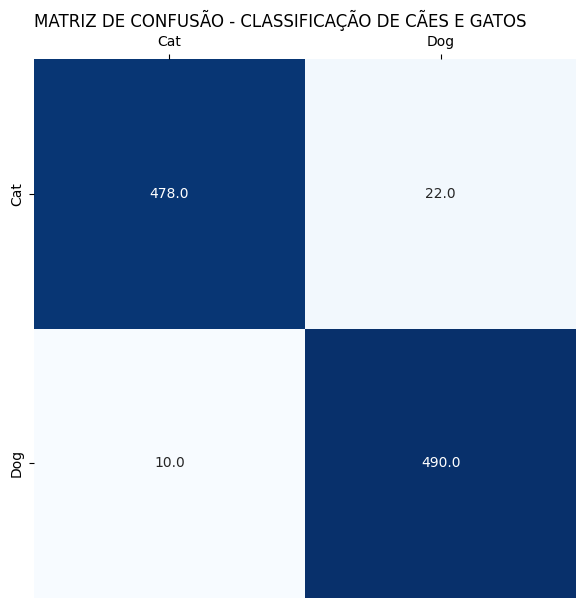

In [154]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.title(title, loc='left')
plt.show()


    Pela matriz podemos ver que o modelo acertou 478 gatos dos 500 e errou 22.
    O modelo acertou 490 Cães e classificou 10 de forme equivocada.


In [155]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       500
           1       0.96      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



Salvar e carregar a rede neural

In [156]:
# Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [157]:
# Salvando os pesos das camadas.
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

<ipython-input-157-a8aee2308f3c>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')


In [158]:
# visualizando o arquivo.json
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model_3", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_6"}, "registered_name": null, "name": "input_6", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constrai

In [159]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Classificação de uma única imagem

In [160]:
# carregando uma imagem
imagem = cv2.imread('/content/cat_dog/test_set/cat/cat.3506.jpg')

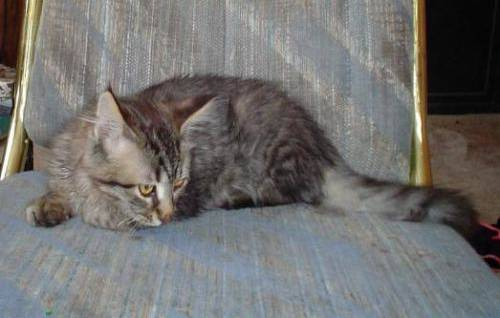

In [161]:
cv2_imshow(imagem)

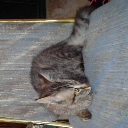

In [162]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem = cv2.resize(imagem, (128, 128))
imagem = cv2.rotate(imagem, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(imagem)

In [163]:
# Normalizando a imagem.
imagem = imagem / 255
imagem

array([[[0.03921569, 0.03921569, 0.03921569],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03137255, 0.03137255, 0.03137255],
        ...,
        [0.47843137, 0.43921569, 0.35686275],
        [0.48235294, 0.43137255, 0.34509804],
        [0.48627451, 0.44313725, 0.34509804]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.45882353, 0.41960784, 0.36470588],
        [0.45882353, 0.41960784, 0.34901961],
        [0.4627451 , 0.41568627, 0.34509804]],

       [[0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.49411765, 0.43529412, 0.38039216],
        [0.4627451 , 0.4       , 0.33333333],
        [0.47843137, 0.41568627, 0.34901961]],

       ...,

       [[0.05490196, 0.12941176, 0.23529412],
        [0.04313725, 0.11764706, 0.22352941],
        [0.04313725, 0

In [164]:
# Conferindo o formato
imagem.shape

(128, 128, 3)

In [165]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem = imagem.reshape(1,128,128,3)

In [166]:
# Realizando a previsão.
previsao = network_loaded(imagem)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.95366585, 0.04633416]], dtype=float32)>

In [167]:
previsao = np.argmax(previsao)
previsao

0

In [168]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [169]:
if previsao == 0:
  print('O modelo identificou que o animal é um: Gato')
else:
  print('O modelo identificou que o animal é um: Cão')

O modelo identificou que o animal é um: Gato
